[![Open In Colab](./colab-badge.png)](https://colab.research.google.com/github/subhacom/moose-notebooks/blob/main/Action_potentials_Na_channel.ipynb) [![Binder](./binder_logo.png)](https://mybinder.org/v2/gh/subhacom/moose-notebooks/HEAD?labpath=Action_potentials_Na_channel.ipynb)

If you are using `colab`, in a fresh runtime you need to run pip to install pymoose there. On the other hand, if you are running jupyter locally and have pymoose installed in that environment, skip the line below.

In [1]:
## Only required on colab!
# !pip install pymoose --quiet

# Action potentials and Hodgkin-Huxley model: $Na^+$ channel

We already saw how to model $K^{+}$ channel in moose. $K^{+} channel conductance increases with time at depolarized voltages until reaching a steady state.

Hodgkin and Huxley found that $Na^{+}$ channel conductance has more interesting dynamics. It first increases and then decreases.

 [<img src="HH_equivalent_circuit.svg" width="250"/>](HH_equivalent_circuit.svg)

They figured out that the $Na^{+}$ conductance evolves as 

$G_{Na} = \bar{G}_{Na} m^{3}\ h$

where $\bar{G}_{Na}$ is the maximum value of $G_{Na}$.
They postulated that like $K^{+}$ channel, $Na^{+}$ channel had 4 gating particles. But 3 of these particles (corresponding to the $m$ in the above equation) helped open the channel while 1 (corresponding to $h$) tried to close the channel at depolarized voltages. 

The transition between open and closed states for both kinds of particle could be modeled as a first order chemical reaction. 

## $m$ gate
For the first kind, if $m$ fraction is open, and the particles switch from open to closed at the rate $\beta_{m}$, then the fraction of open particles reduces at the rate $\beta_{m} m$.

If particles switch from closed to open state at rate $\alpha_{m}$, then the fraction of open particles increases at the rate $\alpha_{m} (1 - m)$, since  $(1-m)$ is the fraction that is in closed state. Thus the rate of change of open fraction is:

$\frac{dm}{dt} = \alpha_{m} (1 - m) - \beta_{m} m$

The solution to this first order differential equation is

$m = m_{\infty} - (m_{\infty} - m_{0})\ exp (-t/\tau_{m})$

where

$m_{\infty} = \frac{\alpha_{m}}{\alpha_{m} + \beta_{m}}$,

and

$\tau_{m} = \frac{1}{\alpha_{m} + \beta_{m}}$

$\alpha_{m}$ and $\beta_{m}$ are the steady state values of the rate constant, and depend on the voltage. Thus $m_{\infty}$ and $\tau_{m}$ are also functions of voltage.

We can also express $\alpha_{m}$ and $\beta_{m}$ in terms of $m_{\infty}$ and $\tau_{m}$ :

$\alpha_{m} = m_{\infty}/\tau_{m}$

and $\beta_{m} = (1 - m_{\infty})/\tau_{m}$



For squid giant axon

$\alpha_{m} = 0.1 (25 - V)/(exp(\frac{25-V}{10}) - 1)$

and 

$\beta_{m} = 4\ exp(\frac{-V}{18})$


## $h$ gate
In the same way, if $h$ fraction of the inactivation particles is open, then

$\frac{dh}{dt} = \alpha_{h} (1 - h) - \beta_{h} h$

The solution to this first order differential equation is

$h = h_{\infty} - (h_{\infty} - h_{0})\ exp (-t/\tau_{h})$


where

$h_{\infty} = \frac{\alpha_{h}}{\alpha_{h} + \beta_{h}}$,

and

$\tau_{h} = \frac{1}{\alpha_{h} + \beta_{h}}$

$\alpha_{h}$ and $\beta_{h}$ are the steady state values of the rate constant, and depend on the voltage. Like before, $h_{\infty}$ and $\tau_{h}$ are also functions of voltage, and

$\alpha_{h} = h_{\infty}/\tau_{h}$

and $\beta_{h} = (1 - h_{\infty})/\tau_{h}$

Hodgkin and Huxley fit the parameters for the $h$ gates with the following formulae:

$\alpha_{h} = 0.07\ exp(\frac{-V}{20})$

and 

$\beta_{h} = 1/(exp(\frac{30-V}{10}) + 1)$


In [2]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

import moose

In [3]:
# Create containers

container = moose.Neutral('/sim')
data = moose.Neutral('/sim/data')
model = moose.Neutral('/sim/model')

In [4]:
# Create a compartment representing the squid giant axon
axon = moose.Compartment(f'{model.path}/axon')

## Insert a channel into the compartment
In moose, Hodgkin-Huxley type channels are implemented by the `HHChannel` class. The channel needs $V_{m}$ of the compartment to update its conductance $G_{k}$, and the compartment needs the channels conductance to compute the current flowing in, and thus to update the voltage. We have to connect the `channel` message of the `HHChannel` object to the `channel` message of the `Compartment` object so the channel conductance and membrane voltage can be communicated between the channel and the compartment.

In [5]:
# Create a Hodgkin-Huxley-type channel and connect it to the compartment
nachan = moose.HHChannel(f'{axon.path}/Na')
moose.connect(nachan, 'channel', axon, 'channel')
moose.showmsg(nachan.path)

INCOMING:
  /sim[0]/model[0]/axon[0]/Na[0], [parentMsg] <-- /sim[0]/model[0]/axon[0], [childOut]
  /sim[0]/model[0]/axon[0]/Na[0], [process,reinit] <-- /clock[0], [process4,reinit4]

OUTGOING:
  /sim[0]/model[0]/axon[0]/Na[0], [childOut] --> /sim[0]/model[0]/axon[0]/Na[0]/gateX[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/Na[0], [childOut] --> /sim[0]/model[0]/axon[0]/Na[0]/gateY[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/Na[0], [childOut] --> /sim[0]/model[0]/axon[0]/Na[0]/gateZ[0], [parentMsg]
  /sim[0]/model[0]/axon[0]/Na[0], [channelOut] --> /sim[0]/model[0]/axon[0], [handleChannel]



$Na^{+}$ channel has two gates, where the $m$ component gets raised to the power 3 and the $h$ component gets raised to the power 1.
`HHChannel` class in moose provides option for 3 gates, X, Y and Z. Here we need only the X and Y gates to model $m$ and $h$.

We first set the exponents for these components:

In [6]:
nachan.Xpower = 3
nachan.Ypower = 1

We have to set the reversal potential of the channel as well as the maximum conductance

In [7]:
nachan.Ek = 115.0   # mV with respect to resting Vm
# Gbar is maximum conductance. 
# The voltage dependent conductance value is computed and 
# stored in the field Gk, which we record in a table below
nachan.Gbar = 120.0  # mS/cm^2

### Setting up gate dynamics

Like $K^{+}$ channel before we can now set the gate parameters, but for X and Y gate separately

In [8]:
xgate = moose.element(f'{nachan.path}/gateX')
ygate = moose.element(f'{nachan.path}/gateY')

xgate.alphaExpr = '0.1 * (25 - v) / (exp((25 - v) / 10) - 1)'
xgate.betaExpr = '4 * exp(-v/18)'

ygate.alphaExpr = '0.07 * exp(-v/20)'
ygate.betaExpr = '1 / (exp((30 - v) / 10) + 1)'
for g in (xgate, ygate):   # looping to avoid repeating the same code for each gate
    g.divs = 150
    g.min = -30.0
    g.max = 120.0


### Alternative (legacy) method:

Again, we could use the more general equation for channel parameters:

$y(x) = \frac{A + B\ x}{C + exp(\frac{x + D}{F})}$ where $x$ is the voltage and $y$ is the voltage dependent rate constant.


Here

$A = 0.1 * 25 = 2.5$, $B = -0.1$, $C = -1$, $D = -25$, and $F = -10$ for $\alpha_{m}$ and 

$A=4$, $B=0$, $C=0$, $D = 0$, and $F=-18$ for $\beta_{m}$.


For $h$ gate, $\alpha_{h}$ can be parameterized with

$A=0.07$, $B=0$, $C=0$, $D = 0$, and $F=-20$

and $\beta_{h}$ with

$A = 1$, $B = 0$, $C = 1$, $D = -30$, and $F = -10$.

```python

vdivs = 150
vmin = -30.0
vmax = 120.0

xgate = moose.HHGate(f'{nachan.path}/gateX')
x_alpha_params = [2.5, -0.1, -1.0, -25.0, -10.0]
x_beta_params = [4, 0, 0, 0, 18.0]
# Note that `+` operator with lists as operands concatenates them
x_params = x_alpha_params + x_beta_params + [vdivs, vmin, vmax]
xgate.setupAlpha(x_params)

ygate = moose.HHGate(f'{nachan.path}/gateY')
y_alpha_params = [0.07, 0, 0, 0, 20.0]
y_beta_params = [1, 0, 1, -30, -10.0]
# Note that `+` operator with lists as operands concatenates them
y_params = y_alpha_params + y_beta_params + [vdivs, vmin, vmax]
ygate.setupAlpha(y_params)
```

/var/folders/p_/xskpv9tj67vb17xz1wmnps2r0000gn/T/ipykernel_5491/2488572131.py:8: RuntimeWarning: invalid value encountered in divide
  x_alpha_hh = 0.1 * (-v + 25) / (np.exp((-v + 25)/10) - 1)


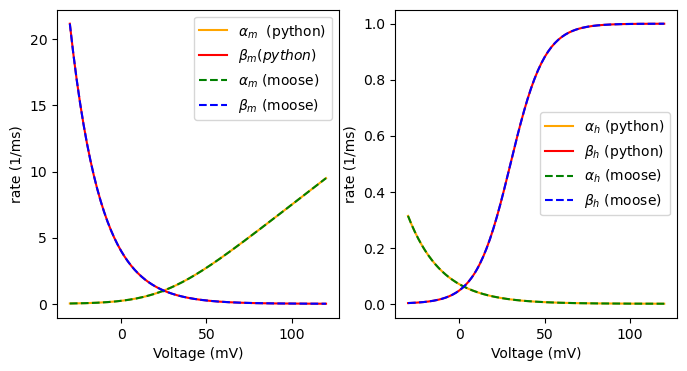

In [9]:
#print(moose.showfields(gate))
xgate.fillFromExpr()
ygate.fillFromExpr()
x_alpha_moose = xgate.tableA
x_beta_moose = xgate.tableB - xgate.tableA
v = np.linspace(xgate.min, xgate.max, len(x_alpha_moose))

x_alpha_hh = 0.1 * (-v + 25) / (np.exp((-v + 25)/10) - 1)
x_beta_hh = 4 * np.exp(-v/18)

plt.subplot(121)
plt.plot(v, x_alpha_hh, '-', color='orange', label=r'$\alpha_{m}$  (python)')
plt.plot(v, x_beta_hh,  '-', color='red', label=r'$\beta_{m} (python)$')
plt.plot(v, x_alpha_moose, '--', color='green', label=r'$\alpha_{m}$ (moose)')
plt.plot(v, x_beta_moose,  '--', color='blue', label=r'$\beta_{m}$ (moose)')

plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel('rate (1/ms)')

plt.subplot(122)
y_alpha_moose = ygate.tableA
y_beta_moose = ygate.tableB - ygate.tableA

y_alpha_hh = 0.07 * np.exp(-v/20)
y_beta_hh = 1/(np.exp((-v + 30)/10) + 1)

plt.plot(v, y_alpha_hh, '-', color='orange', label=r'$\alpha_{h}$ (python)')
plt.plot(v, y_beta_hh,  '-', color='red', label=r'$\beta_{h}$ (python)')
plt.plot(v, y_alpha_moose, '--', color='green', label=r'$\alpha_{h}$ (moose)')
plt.plot(v, y_beta_moose,  '--', color='blue', label=r'$\beta_{h}$ (moose)')
plt.xlabel('Voltage (mV)')
plt.ylabel('rate (1/ms)')
plt.legend()
plt.gcf().set_size_inches(8,4)

Plots of open fractions $m_{\infty}$ and $h_{\infty}$ against voltage gives an idea of how channel conductance changes with voltage. Plots of the time constants $\tau_{m}$ and $\tau_{h}$ are useful for understanding its time course.

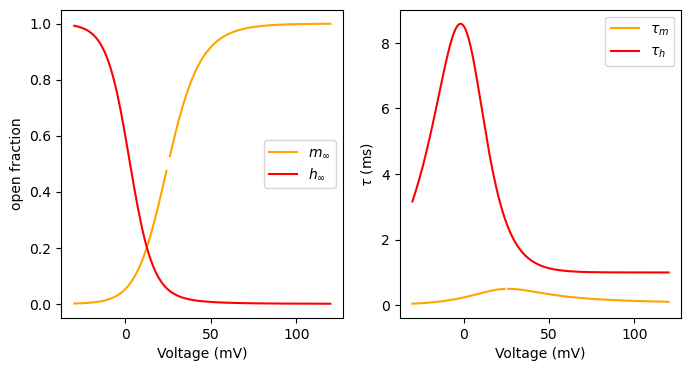

In [10]:
#print(moose.showfields(gate))
plt.subplot(121)
plt.plot(v, x_alpha_hh/(x_alpha_hh+x_beta_hh), '-', color='orange', label=r'$m_{\infty}$')
plt.plot(v, y_alpha_hh/(y_alpha_hh+y_beta_hh), '-', color='red', label=r'$h_{\infty}$')
plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel(r'open fraction')

plt.subplot(122)
plt.plot(v, 1/(x_alpha_hh+x_beta_hh),  '-', color='orange', label=r'$\tau_{m}$')
plt.plot(v, 1/(y_alpha_hh+y_beta_hh),  '-', color='red', label=r'$\tau_{h}$')
plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel(r'$\tau$ (ms)')
plt.gcf().set_size_inches(8, 4)

## Create the voltage clamp setup
Code for setting up voltage clamp 

In [11]:
###################################################
# Do not touch this code
###################################################
def create_voltage_clamp(modelpath, datapath, compartment):
    """Creates a voltage clamp object under `modelpath` and 
    a table under `datapath` to record the command voltage.
    
    Returns the `moose.PulseGen` that gives the command value 
    to the voltage clamp.
    """
    path = f'{modelpath}/elec'  # create a separate container for electronics
    
    if moose.exists(path):   # avoid duplicate connect
        print(f'{path}: Object already exists')
        vclamp = moose.VClamp(f'{path}/vclamp')
        command = moose.PulseGen(f'{path}/command')
        command_tab = moose.Table(f'{datapath}/command')
        return vclamp, command, command_tab
    elec = moose.Neutral(path)    
    vclamp = moose.VClamp(f'{path}/vclamp')
    # The voltage clamp's output is `currentOut` which will be 
    # injected into the compartment
    moose.connect(vclamp, 'currentOut', compartment, 'injectMsg')
    # The voltage clamp object senses the voltage of the compartment
    moose.connect(compartment, 'VmOut', vclamp, 'sensedIn')
    command = moose.PulseGen(f'{path}/command')

    # Connect the output of the command pulse to the command input of the voltage clamp circuit
    moose.connect(command, 'output', vclamp, 'commandIn')

    # Also setup a table to record the command voltage of the VClamp directly
    command_tab = moose.Table(f'{datapath}/command')
    moose.connect(command_tab, 'requestOut', command, 'getOutputValue')
    
    # compartment.dt is the integration time step for the compartment 
    # `tau` is the time constant of the RC filter in the circuit.
    # 5 times the integration timestep value is a good starting point for tau
    vclamp.tau = 5 * compartment.dt
    # `gain` is the proportional gain of the PID controller. `Cm/dt` is a good value
    vclamp.gain = compartment.Cm / compartment.dt

    # `ti` is the integral time of the PID controller, `dt` is a good value
    vclamp.ti = compartment.dt
    # `td` is the derivative time of the PID controller. We can set it to 0
    
    return vclamp, command, command_tab


def set_command_timecourse(command, base, delay, level):
    """Set up an existing pulse generator `command` to output `base` as initial value 
    and `level` after `delay` time"""
    command.baseLevel = base   
    command.firstDelay = delay   
    command.secondDelay = 1e9    # Never stop 
    command.firstWidth = 1e9     # Never stop
    command.firstLevel = level  

### Call the function above to actually create the voltage clamp circuit

In [12]:
# Insert voltage clamp circuitry
vclamp, command, command_tab = create_voltage_clamp(model.path, data.path, axon)
# baseline is set to equilibrium potential
# delay is 10 ms, start the voltage change at this time
# command level is -60 mV, which is 10 mV above equilibrium potential
set_command_timecourse(command, 0.0, 10.0, 10.0)

## Set the passive properties of the compartment

In [13]:
axon.Em = 0    # Hodgkin and Huxley used resting voltage as 0
axon.initVm = 0
axon.Cm = 1
axon.Rm = 1 / 0.3   # G_leak is 0.3 mS/cm^2

## Set up data recording
We have to setup tables to record membrane current as well as K+ conductance 

In [14]:
gNa_tab = moose.Table(f'{data.path}/gNa')
moose.connect(gNa_tab, 'requestOut', nachan, 'getGk')
im_tab = moose.Table(f'{data.path}/Im')
moose.connect(im_tab, 'requestOut', axon, 'getIm')

<moose.SingleMsg id=5 dataIndex=6 path=/Msgs[0]/singleMsg[6]>

## Setup scheduling (optional), initialize the model, and run the simulation

As mentioned in the K channel notebook, to work around an issue in moose, we need to explicitly schedule in what order various objects are updated during the simulation. This is done via the `setClock` and `useClock` functions.

`useClock(n, path)` schedules object(s) in path `path` on clock number `n`. That means every time clock # `n` ticks, some functions to update the state of the object at `path` get called.

`setClock(n, dt)` sets the tick interval (in simulated time) of clock number `n` to `dt`. This may also be used as the timestep for temporal integration when updating the object involves solving a differential equation.



In [15]:
## Uncomment below if you see an initial voltage transient when repeating the simulation

# simdt = 1e-5   # simulation timestep
# plotdt = 1e-3  # data collection timestep

# moose.setClock(0, simdt)
# moose.setClock(1, simdt)
# moose.setClock(2, simdt)
# moose.setClock(3, plotdt)

# # moose uses `#` character as a wildcard. 
# # "/model/#" gets all objects that are children of `/model`.
# # "/model/#[TYPE=Compartment]" gets all `Compartment` instances that are children of `/model`.
# # "/model/##" gets all objects that are descendants (children, grand children, ...) of `/model`.

# moose.useClock(0, f'{model.path}/#[TYPE=Compartment]', 'init')
# moose.useClock(1, f'{model.path}/elec/##', 'process')
# moose.useClock(1, f'{model.path}/#[TYPE=Compartment]', 'process')
# moose.useClock(2, f'{axon.path}/#[TYPE=HHChannel]', 'process')
# moose.useClock(3, f'{data.path}/#[TYPE=Table]', 'process')


Now run the simulation

In [16]:
runtime = 50
# `reinit` initialize the simulation 
moose.reinit()
# run the simulation for `runtime` duration
moose.start(runtime)

## Plot the results

Text(0.5, 0, 'Time (ms)')

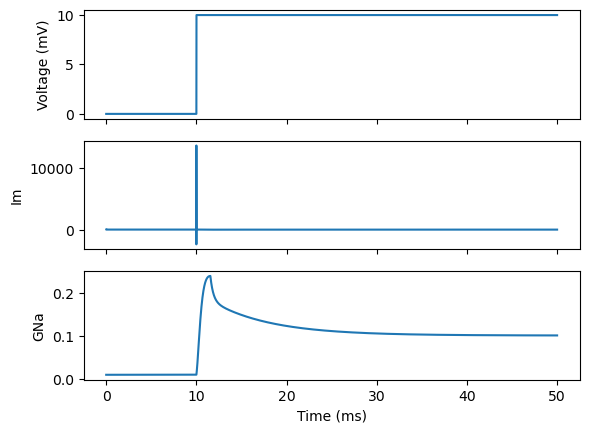

In [17]:
v_command = command_tab.vector
t_command = np.arange(len(v_command)) * command_tab.dt
fig, axes = plt.subplots(nrows=3, ncols=1, sharex='all')
axes[0].plot(t_command, v_command, label='Command voltage')
axes[0].set_ylabel('Voltage (mV)')

im = im_tab.vector
t_im = np.arange(len(im)) * im_tab.dt
axes[1].plot(t_im, im, label='Membrane current (mA/cm^2)')
axes[1].set_ylabel('Im')
#plt.plot(t_v, v_end, ':', label='Voltage at last compartment')
gNa = gNa_tab.vector
t_gNa = np.arange(len(gNa)) * gNa_tab.dt
axes[2].plot(t_gNa, gNa)
axes[2].set_ylabel('GNa')
axes[2].set_xlabel('Time (ms)')

## Simulating Hodgkin and Huxleys experiment with different voltage steps
Hodgkin and Huxley first identified the properties of the $K^{+}$ conductance by stepping the command voltage to various values (6, 10, 19, 26, 32, 38, 51, 63, 76, 88, 100, 109 mV above resting value). To do this we can repeat the simulation by changing the command voltage in our voltage clamp, and accumulating the time series of GK. We already defined the function `set_command_time_course(command, base, delay, level)` which we can use in a loop to update the level and rerun the simulation.

Text(0, 0.5, 'Conductivity (mS/cm^2)')

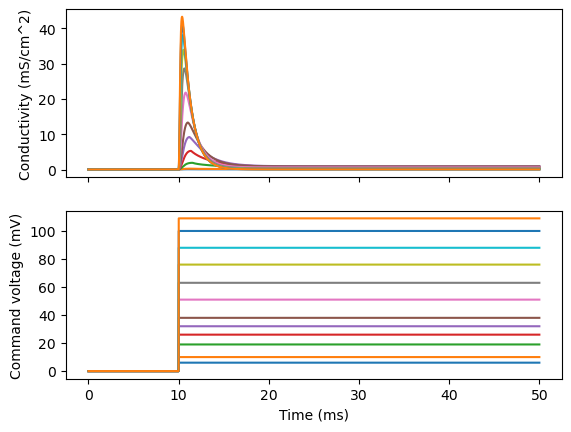

In [18]:
commands = np.r_[6, 10, 19, 26, 32, 38, 51, 63, 76, 88, 100, 109]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex='all')

for level in commands:
    set_command_timecourse(command, 0.0, 10.0, level)
    moose.reinit()
    moose.start(runtime)
    gNa = gNa_tab.vector
    t_gNa = np.arange(len(gNa)) * gNa_tab.dt
    axes[0].plot(t_gNa, gNa, label=f'{level} mV')
    v_command = command_tab.vector
    t_command = np.arange(len(v_command)) * command_tab.dt
    axes[1].plot(t_command, v_command)


axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Command voltage (mV)')
axes[0].set_ylabel('Conductivity (mS/cm^2)')

## Exercises
1. Collect the final steady state values of the $Na^{+}$ conductance from the simulation and plot against the command voltage.